In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from scipy.stats.mstats import winsorize
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score,make_scorer
from imblearn.over_sampling import ADASYN, SMOTE
import warnings
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier


df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Mia_proyect/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Mia_proyect/test.csv")

In [91]:
#Cambio de nombre de las columnas
df = df.rename(columns={
    "age": "edad",
    "sex": "sexo",
    "cp": "tipo_dolor_pecho",
    "trestbps": "tension_en_descanso",
    "chol": "colesterol",
    "fbs": "azucar",
    "restecg": "electro_en_descanso",
    "thalach": "latidos_por_minuto",
    "exang": "dolor_pecho_con_ejercicio",
    "oldpeak": "cambio_linea_corazon_ejercicio",
    "slope": "forma_linea_corazon_ejercicio",
    "ca": "num_venas_grandes",
    "thal": "estado_corazon_thal"
})
df_test = df_test.rename(columns={
    "age": "edad",
    "sex": "sexo",
    "cp": "tipo_dolor_pecho",
    "trestbps": "tension_en_descanso",
    "chol": "colesterol",
    "fbs": "azucar",
    "restecg": "electro_en_descanso",
    "thalach": "latidos_por_minuto",
    "exang": "dolor_pecho_con_ejercicio",
    "oldpeak": "cambio_linea_corazon_ejercicio",
    "slope": "forma_linea_corazon_ejercicio",
    "ca": "num_venas_grandes",
    "thal": "estado_corazon_thal"
})


In [92]:
# Remplazamos los -9 por nan y aseguramos que todas las columnas numéricas sean numéricas

# Función para procesar un DataFrame
def preprocess_df(df_input):
    df = df_input.copy()
    # Primero, intentamos convertir todas las columnas a numéricas, coercing errores
    # Esto convertirá '?' y otros valores no numéricos a NaN
    for col in df.columns:
        # Excluimos la columna 'label' si existe, ya que es el target y no debe ser convertida de esta forma
        if col != 'label':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Ahora, reemplazamos -9 por NaN en todas las columnas numéricas resultantes
    # Esta línea ahora es más efectiva ya que todas las columnas que deberían ser numéricas ya lo son o son NaN
    for col in df.select_dtypes(include=['number']).columns:
        df[col] = df[col].replace(-9, np.nan)
    return df

df = preprocess_df(df)
df_test = preprocess_df(df_test)

In [93]:


def impute_missing_values(df_input):
    df = df_input.copy()

    numeric_cols_to_impute = [
        'tension_en_descanso', 'colesterol', 'azucar', 'latidos_por_minuto',
        'dolor_pecho_con_ejercicio', 'cambio_linea_corazon_ejercicio',
        'forma_linea_corazon_ejercicio', 'num_venas_grandes', 'estado_corazon_thal'
    ]

    for col in numeric_cols_to_impute:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Now fill missing values using median or mode
    df['tension_en_descanso'] = df['tension_en_descanso'].fillna(df['tension_en_descanso'].median())
    df['colesterol'] = df['colesterol'].fillna(df['colesterol'].median())
    df['azucar'] = df['azucar'].fillna(df['azucar'].mode()[0])
    df['latidos_por_minuto'] = df['latidos_por_minuto'].fillna(df['latidos_por_minuto'].median())
    df['dolor_pecho_con_ejercicio'] = df['dolor_pecho_con_ejercicio'].fillna(df['dolor_pecho_con_ejercicio'].mode()[0])
    df['cambio_linea_corazon_ejercicio'] = df['cambio_linea_corazon_ejercicio'].fillna(df['cambio_linea_corazon_ejercicio'].median())
    df['forma_linea_corazon_ejercicio'] = df['forma_linea_corazon_ejercicio'].fillna(df['forma_linea_corazon_ejercicio'].mode()[0])
    df['num_venas_grandes'] = df['num_venas_grandes'].fillna(df['num_venas_grandes'].mode()[0])
    df['estado_corazon_thal'] = df['estado_corazon_thal'].fillna(df['estado_corazon_thal'].mode()[0])
    # df['num_venas_grandes'] = df['num_venas_grandes'].fillna(0)
    # df['estado_corazon_thal'] = df['estado_corazon_thal'].fillna(0)

    return df


df_imputed = impute_missing_values(df.copy())
df_test_imputed = impute_missing_values(df_test.copy())



print("DataFrame (df) after imputation (head):")
display(df_imputed.head())
print("DataFrame (df_test) after imputation (head):")
display(df_test_imputed.head())


DataFrame (df) after imputation (head):


,edad,sexo,tipo_dolor_pecho,tension_en_descanso,colesterol,azucar,electro_en_descanso,latidos_por_minuto,dolor_pecho_con_ejercicio,cambio_linea_corazon_ejercicio,forma_linea_corazon_ejercicio,num_venas_grandes,estado_corazon_thal,label
0,51.0,1.0,1.0,125.0,213.0,0.0,2.0,125.0,1.0,1.4,1.0,1.0,3.0,0
1,54.0,1.0,3.0,120.0,237.0,0.0,0.0,150.0,1.0,1.5,2.0,0.0,7.0,2
2,63.0,1.0,4.0,140.0,0.0,0.0,2.0,149.0,0.0,2.0,1.0,0.0,7.0,2
3,52.0,0.0,2.0,140.0,223.0,0.0,0.0,140.0,0.0,0.0,2.0,0.0,7.0,0
4,55.0,1.0,4.0,140.0,217.0,0.0,0.0,111.0,1.0,5.6,3.0,0.0,7.0,3


DataFrame (df_test) after imputation (head):


,edad,sexo,tipo_dolor_pecho,tension_en_descanso,colesterol,azucar,electro_en_descanso,latidos_por_minuto,dolor_pecho_con_ejercicio,cambio_linea_corazon_ejercicio,forma_linea_corazon_ejercicio,num_venas_grandes,estado_corazon_thal
0,57.0,1.0,4.0,156.0,173.0,0.0,2.0,119.0,1.0,3.0,3.0,0.0,3.0
1,52.0,1.0,2.0,160.0,196.0,0.0,0.0,165.0,0.0,0.0,2.0,0.0,3.0
2,48.0,1.0,2.0,100.0,221.0,0.0,0.0,100.0,0.0,0.0,2.0,0.0,3.0
3,62.0,1.0,4.0,115.0,0.0,0.0,0.0,128.0,1.0,2.5,3.0,0.0,3.0
4,51.0,1.0,3.0,110.0,175.0,0.0,0.0,123.0,0.0,0.6,1.0,0.0,3.0


In [94]:


warnings.filterwarnings("ignore")  # evitar warnings por penalizaciones

X = df_imputed.drop('label', axis=1) # Drop the target column to get features
y = df_imputed['label'] # Select the target column

# Now, split the features and target into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# smote = SMOTE(sampling_strategy='not majority', random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)
# Lista de configuraciones a probar
configuraciones = [
    {"penalty": "l2", "solver": "lbfgs"},
    {"penalty": "l1", "solver": "liblinear"},
    {"penalty": "elasticnet", "solver": "saga", "l1_ratio": 0.5},
    {"penalty": "none", "solver": "lbfgs"}
]

for config in configuraciones:
    print(f"\n🔍 Configuración: {config}")
    try:
        modelo = LogisticRegression(max_iter=1000, multi_class='auto', random_state=42, **config)
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        y_proba = modelo.predict_proba(X_test)

        print(classification_report(y_test, y_pred))
        print("F1 weighted:", f1_score(y_test, y_pred, average='weighted'))
        print("AUC:", roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted'))
    except Exception as e:
        print("❌ Error en esta configuración:", e)



🔍 Configuración: {'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.72      0.86      0.79        66
           1       0.37      0.35      0.36        31
           2       0.33      0.11      0.17        18
           3       0.26      0.36      0.30        22
           4       0.00      0.00      0.00        10

    accuracy                           0.53       147
   macro avg       0.34      0.34      0.32       147
weighted avg       0.48      0.53      0.49       147

F1 weighted: 0.4946360032328471
AUC: 0.781047598369016

🔍 Configuración: {'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.70      0.88      0.78        66
           1       0.37      0.35      0.36        31
           2       0.40      0.11      0.17        18
           3       0.34      0.45      0.39        22
           4       0.00      0.00      0.00        10

    accuracy    

In [95]:

#Sacar los mejores parametros de la regresion Logistica


pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=2000))
])

param_grid = {
    'lr__penalty': ['l2'],
    'lr__C': [0.01, 0.1, 1, 10],
    'lr__solver': ['lbfgs'],
    'lr__class_weight': [None, 'balanced']
}

grid = GridSearchCV(pipe, param_grid, scoring='f1_weighted', cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

best_lr = grid.best_estimator_
print("Mejores parámetros:", grid.best_params_)


Mejores parámetros: {'lr__C': 1, 'lr__class_weight': None, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}


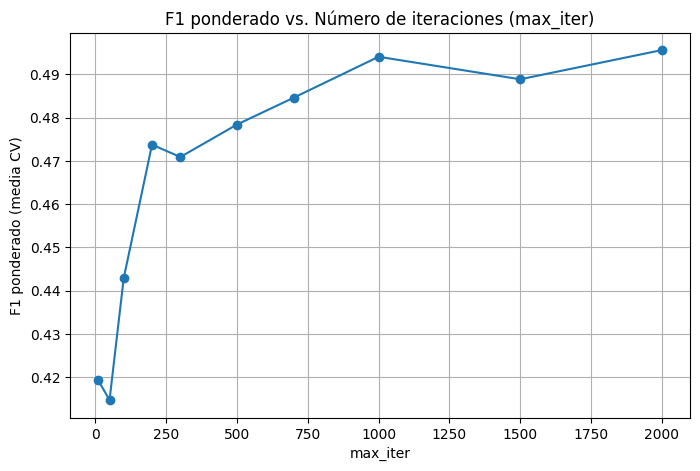

In [96]:
# Valores de max_iter a probar
iteraciones = [10, 50, 100, 200, 300, 500, 700, 1000, 1500, 2000]
f1_scores = []

# Recorremos los valores y evaluamos con cross-validation
for i in iteraciones:
    modelo = LogisticRegression(max_iter=i, class_weight='balanced', solver='lbfgs')
    score = cross_val_score(modelo, X_train, y_train, cv=3, scoring='f1_weighted').mean()
    f1_scores.append(score)

# Graficar
plt.figure(figsize=(8, 5))
plt.plot(iteraciones, f1_scores, marker='o')
plt.title("F1 ponderado vs. Número de iteraciones (max_iter)")
plt.xlabel("max_iter")
plt.ylabel("F1 ponderado (media CV)")
plt.grid(True)
plt.show()

In [97]:

#Sacar los mejores parametros del Random Forest

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5],
    'class_weight': [None, 'balanced']
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, scoring='f1_weighted', cv=3, n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
print("🔍 RandomForest - Best params:", grid_rf.best_params_)


🔍 RandomForest - Best params: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}


In [98]:
#Sacar los mejores parametros del XGB clasifier
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

grid_xgb = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_grid_xgb,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1
)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
print("🔍 XGBoost - Best params:", grid_xgb.best_params_)


🔍 XGBoost - Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}


In [99]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid_brf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

grid_brf = GridSearchCV(
    BalancedRandomForestClassifier(random_state=42),
    param_grid_brf,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1
)

grid_brf.fit(X_train, y_train)
best_brf = grid_brf.best_estimator_
print("🌲 BalancedRF - Mejores parámetros:", grid_brf.best_params_)


🌲 BalancedRF - Mejores parámetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [100]:
from imblearn.ensemble import EasyEnsembleClassifier

param_grid_eec = {
    'n_estimators': [10, 20],
    'sampling_strategy': ['auto', 0.8]
}

grid_eec = GridSearchCV(
    EasyEnsembleClassifier(random_state=42),
    param_grid_eec,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1
)

grid_eec.fit(X_train, y_train)
best_eec = grid_eec.best_estimator_
print("🧩 EasyEnsemble - Mejores parámetros:", grid_eec.best_params_)


🧩 EasyEnsemble - Mejores parámetros: {'n_estimators': 10, 'sampling_strategy': 'auto'}


In [101]:

#VotingClassifier (votación por probabilidad)

# Crear el ensamblado con los modelos optimizados
voting_clf = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('brf', best_brf),
        ('eec', best_eec)

    ],
    voting='soft'  # usa las probabilidades de cada modelo
)

# Entrenar
voting_clf.fit(X_train, y_train)

# Predecir
y_pred = voting_clf.predict(X_test)
y_proba = voting_clf.predict_proba(X_test)
# Sin SMOTE : F1 (weighted): 0.47918708779171115
# Con SMOTE : F1 (weighted): 0.48118708779171115
# Evaluación
print("🔍 Ensamblado VotingClassifier")
print(classification_report(y_test, y_pred))
print("F1 (weighted):", f1_score(y_test, y_pred, average='weighted'))


# 3. Definir validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Evaluar el modelo usando F1 ponderado
f1 = make_scorer(f1_score, average='weighted')
scores = cross_val_score(voting_clf, X, y, cv=cv, scoring=f1)

# 5. Mostrar resultados
print("⚙️ F1 ponderado por fold:", scores)
print("✅ F1 promedio:", np.mean(scores))

print("AUC (ovr):", roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted'))


🔍 Ensamblado VotingClassifier
              precision    recall  f1-score   support

           0       0.74      0.85      0.79        66
           1       0.40      0.26      0.31        31
           2       0.24      0.28      0.26        18
           3       0.26      0.32      0.29        22
           4       0.00      0.00      0.00        10

    accuracy                           0.52       147
   macro avg       0.33      0.34      0.33       147
weighted avg       0.48      0.52      0.49       147

F1 (weighted): 0.49444168112480513
⚙️ F1 ponderado por fold: [0.537158   0.50472584 0.47453904 0.53898212 0.49027524]
✅ F1 promedio: 0.5091360467051095
AUC (ovr): 0.7829249889867046


In [ ]:

# StackingClassifier
stacking_clf = StackingClassifier(
    estimators=[
        ('lr', best_lr),
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('brf', best_brf),
        ('eec', best_eec)
    ],
    final_estimator=LogisticRegression(max_iter=1000)
)

stacking_clf.fit(X_train, y_train)
y_pred = stacking_clf.predict(X_test)
y_proba = stacking_clf.predict_proba(X_test)
# Stacking con moda: F1 (weighted): 0.49961299352276806

print("🔍 Ensamblado StackingClassifier")
print(classification_report(y_test, y_pred))
print("F1 (weighted):", f1_score(y_test, y_pred, average='weighted'))
# 3. Definir validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Evaluar el modelo usando F1 ponderado
f1 = make_scorer(f1_score, average='weighted')
scores = cross_val_score(stacking_clf, X, y, cv=cv, scoring=f1)

# 5. Mostrar resultados
print("⚙️ F1 ponderado por fold:", scores)
print("✅ F1 promedio:", np.mean(scores))
print("AUC (ovr):", roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted'))


🔍 Ensamblado StackingClassifier
              precision    recall  f1-score   support

           0       0.73      0.86      0.79        66
           1       0.36      0.29      0.32        31
           2       0.21      0.17      0.19        18
           3       0.30      0.41      0.35        22
           4       0.00      0.00      0.00        10

    accuracy                           0.53       147
   macro avg       0.32      0.35      0.33       147
weighted avg       0.48      0.53      0.50       147

F1 (weighted): 0.4979909546236077
⚙️ F1 ponderado por fold: [0.51924299 0.46984448 0.50343718 0.49708377 0.51073158]
✅ F1 promedio: 0.5000679977979837
AUC (ovr): 0.7900471466022047


In [ ]:
from sklearn.impute import SimpleImputer

# Usa la misma estrategia que en entrenamiento
imputer = SimpleImputer(strategy='most_frequent')  # o 'median', según tu caso

df_test_clean = pd.DataFrame(imputer.fit_transform(df_test_imputed),
                             columns=df_test_imputed.columns)

# 1. Imputamos los NaNs
imputer = SimpleImputer(strategy='most_frequent')  # cambia si usaste otra
df_test_clean = pd.DataFrame(imputer.fit_transform(df_test_imputed),
                             columns=df_test_imputed.columns)

# 2. Predicción
y_pred_final = voting_clf.predict(df_test_clean)


In [ ]:
# Retrain the stacking_clf on the full training data (X, y)

voting_clf.fit(X, y) # Train on the full imputed training data
# Make predictions on the preprocessed test dataset
y_pred_final = voting_clf.predict(df_test_clean)

# 1. Crear el DataFrame de submission
#    - "id": usamos el índice de df_test_imputed como identificador
#    - "label": las predicciones del mejor modelo sobre el test
submission = pd.DataFrame({
    "ID": df_test_clean.index, # Corrected: Use the index of the test data
    "label": y_pred_final.astype(int) # Use predictions on the test data
})

# 2. Guardar el CSV en tu Google Drive (misma carpeta donde tenías train/test)
output_path = "/content/drive/MyDrive/Colab Notebooks/Mia_proyect/submission.csv"
submission.to_csv(output_path, index=False)

print("✅ Archivo de submission generado:")
print(output_path)
display(submission.head())

✅ Archivo de submission generado:
/content/drive/MyDrive/Colab Notebooks/Mia_proyect/submission.csv


,ID,label
0,0,2
1,1,0
2,2,0
3,3,1
4,4,0
